In [27]:
# Dependencies
import pandas as pd
import requests
import json
import os
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import numpy as np

# Google API Key (maybe later)
from config import gkey


In [28]:
# Source files
attendance_raw = 'Resources/national_park_attendance_Prev3Y.xlsx'
park_info = 'Resources/national_park_locations.xlsx'
#wildfires = 'Resources/California_Fire_Incidents.csv'

# Read data and store in dataframe
attendance_data = pd.read_excel(attendance_raw)
park_info_data = pd.read_excel(park_info)
#wildfire_data = pd.read_csv(wildfires)


In [29]:
# Limit dataframe to California & Florifa
national_parks = park_info_data.loc[(park_info_data['ParkType']=='National Park')]
focus_parks = pd.DataFrame(national_parks.loc[(park_info_data['State'] == 'CA') | (park_info_data['State'] == 'FL')])
focus_parks.reset_index()

#focus_parks['FullName'] = focus_parks['Park']

# Create new 'FullName' column (empty)
focus_parks['FullName'] = focus_parks['Park'].str.replace(['NP'],'')#+focus_parks['ParkType'])

focus_parks['FullName']=focus_parks['Park'].str[:-2]+focus_parks['ParkType']

#focus_parks['Park'].replace('NP', 'National Park', inplace=True)
#focus_parks['Park'] = focus_parks['Park'].str.replace('NP','')

focus_parks.head(20)

,Park,UnitCode,ParkType,Region,State,FullName
30,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park
63,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park
87,Death Valley NP,DEVA,National Park,Pacific West,CA,Death Valley National Park
93,Dry Tortugas NP,DRTO,National Park,Southeast,FL,Dry Tortugas National Park
101,Everglades NP,EVER,National Park,Southeast,FL,Everglades National Park
191,Joshua Tree NP,JOTR,National Park,Pacific West,CA,Joshua Tree National Park
198,Kings Canyon NP,KICA,National Park,Pacific West,CA,Kings Canyon National Park
210,Lassen Volcanic NP,LAVO,National Park,Pacific West,CA,Lassen Volcanic National Park
281,Pinnacles NP,PINN,National Park,Pacific West,CA,Pinnacles National Park
293,Redwood NP,REDW,National Park,Pacific West,CA,Redwood National Park


In [30]:
# Find the geocoordinates (latitude and longitude)
park = "Yellowstone"

params = {"address": park, "key": gkey}

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

#print("Drill #1: The Geocoordinates of X")

# Run request
response = requests.get(base_url, params=params)

# print the response URL, avoid doing for public GitHub repos in order to avoid exposing key
# print(response.url)

# Convert to JSON
park_geo = response.json()

# Extract lat/lng
lat = park_geo["results"][0]["geometry"]["location"]["lat"]
lng = park_geo["results"][0]["geometry"]["location"]["lng"]

# Print results
print(f"{park}: {lat}, {lng}")

Yellowstone: 44.427963, -110.588455


In [31]:
# Build URL using the Google Maps API

lats=[]
longs=[]
cost=[]

base_url = "https://maps.googleapis.com/maps/api/geocode/json"

for Park in focus_parks['FullName']:
    params = {"address": Park, "key": gkey}
    response = requests.get(base_url, params=params)
    park_geo = response.json()
    lats.append(park_geo["results"][0]["geometry"]["location"]["lat"])
    longs.append(park_geo["results"][0]["geometry"]["location"]["lng"])           
    

In [32]:
# Add geocoordinates to dataframe
focus_parks['Latitude']=lats
focus_parks['Longitude']=longs
focus_parks.head()

,Park,UnitCode,ParkType,Region,State,FullName,Latitude,Longitude
30,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310
63,Channel Islands NP,CHIS,National Park,Pacific West,CA,Channel Islands National Park,34.006936,-119.778533
87,Death Valley NP,DEVA,National Park,Pacific West,CA,Death Valley National Park,36.505389,-117.079408
93,Dry Tortugas NP,DRTO,National Park,Southeast,FL,Dry Tortugas National Park,24.633333,-82.920000
101,Everglades NP,EVER,National Park,Southeast,FL,Everglades National Park,25.745929,-80.554956


In [33]:
# Combine the data into a single dataframe  
park_data = pd.merge(focus_parks, attendance_data, how="left", on=["Park", "Park"])
park_data.head()

,Park,UnitCode,ParkType,Region,State,FullName,Latitude,Longitude,Code,Month,Visitors
0,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.20831,BISC,2020-01-01 00:00:00,79041.0
1,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.20831,BISC,2020-02-01 00:00:00,91655.0
2,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.20831,BISC,2020-03-01 00:00:00,10962.0
3,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.20831,BISC,2020-04-01 00:00:00,2358.0
4,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.20831,BISC,2020-05-01 00:00:00,43692.0


In [34]:
park_data['Calendar Year'] = pd.DatetimeIndex(park_data['Month']).year
park_data['Calendar Month'] = pd.DatetimeIndex(park_data['Month']).month
park_data.head(50)

,Park,UnitCode,ParkType,Region,State,FullName,Latitude,Longitude,Code,Month,Visitors,Calendar Year,Calendar Month
0,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-01-01 00:00:00,79041.0,2020,1
1,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-02-01 00:00:00,91655.0,2020,2
2,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-03-01 00:00:00,10962.0,2020,3
3,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-04-01 00:00:00,2358.0,2020,4
4,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-05-01 00:00:00,43692.0,2020,5
5,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-06-01 00:00:00,32646.0,2020,6
6,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-07-01 00:00:00,28770.0,2020,7
7,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-08-01 00:00:00,34416.0,2020,8
8,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-09-01 00:00:00,18276.0,2020,9
9,Biscayne NP,BISC,National Park,Southeast,FL,Biscayne National Park,25.482423,-80.208310,BISC,2020-10-01 00:00:00,17436.0,2020,10


In [35]:
# Split up our data into groups based upon 'bikeid' and 'gender'
year_groups = park_data.groupby(['Calendar Year','Calendar Month'])

# Create a new variable that holds the sum of our groups
sum_it_up = year_groups.sum()
sum_it_up.head(50)

Latitude    Longitude   Visitors
Calendar Year Calendar Month                                    
2017          1               409.688152 -1319.709203   766308.0
              2               409.688152 -1319.709203   713317.0
              3               409.688152 -1319.709203  1016798.0
              4               409.688152 -1319.709203  1161838.0
              5               409.688152 -1319.709203  1284854.0
              6               409.688152 -1319.709203  1353126.0
              7               409.688152 -1319.709203  1652030.0
              8               409.688152 -1319.709203  1583956.0
              9               409.688152 -1319.709203  1296326.0
              10              409.688152 -1319.709203  1082981.0
              11              409.688152 -1319.709203   865442.0
              12              409.688152 -1319.709203   781624.0
2018          1               409.688152 -1319.709203   698100.0
              2               409.688152 -1319.709203   791302.0
              3               409.688152 -1319.709203  1009598.0
              4               409.688152 -1319.709203  1078583.0
              5               409.688152 -1319.709203  1200857.0
              6               409.688152 -1319.709203  1358084.0
              7               409.688152 -1319.709203  1441211.0
              8               409.688152 -1319.709203  1349803.0
              9               409.688152 -1319.709203  1297494.0
              10              409.688152 -1319.709203  1105785.0
              11              409.688152 -1319.709203   904695.0
              12              409.688152 -1319.709203  1017143.0
2019          1               409.688152 -1319.709203   660024.0
              2               409.688152 -1319.709203   745755.0
              3               409.688152 -1319.709203  1236231.0
              4               409.688152 -1319.709203  1288180.0
              5               409.688152 -1319.709203  1288243.0
              6               409.688152 -1319.709203  1396080.0
              7               409.688152 -1319.709203  1662196.0
              8               409.688152 -1319.709203  1645794.0
              9               409.688152 -1319.709203  1435499.0
              10              409.688152 -1319.709203  1288878.0
              11              409.688152 -1319.709203   985016.0
              12              409.688152 -1319.709203   913257.0
2020          1               409.688152 -1319.709203   822438.0
              2               409.688152 -1319.709203   996423.0
              3               409.688152 -1319.709203   514349.0
              4               409.688152 -1319.709203    32645.0
              5               409.688152 -1319.709203   209919.0
              6               409.688152 -1319.709203   797805.0
              7               409.688152 -1319.709203  1254779.0
              8               409.688152 -1319.709203  1089101.0
              9               409.688152 -1319.709203   515273.0
              10              409.688152 -1319.709203   779808.0
              11              409.688152 -1319.709203   995919.0

In [36]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the visutors for each calendar year
# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 


mean = park_data.groupby('Calendar Month').mean()['Visitors']
median = park_data.groupby('Calendar Month').median()['Visitors']
variance = park_data.groupby('Calendar Month').var()['Visitors']
std_dev = park_data.groupby('Calendar Month').std()['Visitors']
SEM = park_data.groupby('Calendar Month').sem()['Visitors']

# Assemble the resulting series into a single summary dataframe.
park_stats = pd.DataFrame({'Mean': mean,
              'Median':median,
              'Variance': variance,
              'Standard Deviation': std_dev,
                         'SEM':SEM})
park_stats.head(12)

,Mean,Median,Variance,Standard Deviation,SEM
Calendar Month,,,,,
1,61393.125000,26234.0,5.287437e+09,72714.764692,10495.472242
2,67641.604167,26092.0,6.314422e+09,79463.338589,11469.544981
3,78687.000000,30803.0,1.175751e+10,108432.049317,15650.818215
4,74192.625000,34330.5,1.086069e+10,104214.648238,15042.088803
5,82997.354167,41381.0,1.157948e+10,107608.006993,15531.877951
6,102189.479167,66044.5,1.572199e+10,125387.345128,18098.104366
7,125212.833333,71268.5,2.400965e+10,154950.472300,22365.174223
8,118096.958333,82618.0,2.083480e+10,144342.638131,20834.065245
9,94679.000000,49345.5,1.742104e+10,131988.775982,19050.938836


In [37]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Using the aggregation method, produce the same summary statistics in a single line
# Google take the wheel ...
summary_stats= park_data.groupby('Park').agg({'Visitors':['mean','median','var','std','sem']})
summary_stats

Visitors                                         \
                             mean    median           var            std   
Park                                                                       
Biscayne NP          42557.829787   41287.0  3.911489e+08   19777.485580   
Channel Islands NP   27484.297872   26302.0  1.832456e+08   13536.825577   
Death Valley NP     115497.978723  122013.0  1.951054e+09   44170.739525   
Dry Tortugas NP       4878.446809    5336.0  4.696603e+06    2167.164645   
Everglades NP        72625.276596   68267.0  1.756495e+09   41910.562984   
Joshua Tree NP      232243.617021  233995.0  8.984922e+09   94788.830975   
Kings Canyon NP      51721.340426   40030.0  1.436163e+09   37896.743394   
Lassen Volcanic NP   41899.361702   12879.0  1.754974e+09   41892.415390   
Pinnacles NP         16544.914894   15829.0  4.572308e+07    6761.884388   
Redwood NP           35815.212766   30938.0  3.509364e+08   18733.297810   
Sequoia NP           96466.787234   83442.0  3.839955e+09   61967.369821   
Yosemite NP         312581.255319  278349.0  3.944555e+10  198609.036258   

                                  
                             sem  
Park                              
Biscayne NP          2884.842766  
Channel Islands NP   1974.548948  
Death Valley NP      6442.964545  
Dry Tortugas NP       316.113453  
Everglades NP        6113.283913  
Joshua Tree NP      13826.372024  
Kings Canyon NP      5527.808153  
Lassen Volcanic NP   6110.636815  
Pinnacles NP          986.322209  
Redwood NP           2732.532326  
Sequoia NP           9038.869872  
Yosemite NP         28970.105385

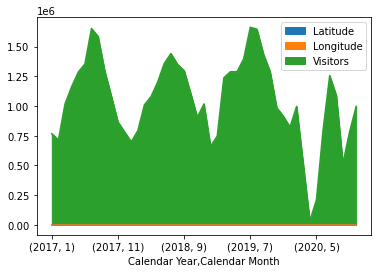

In [38]:
sum_it_up.plot.area()
plt.show()

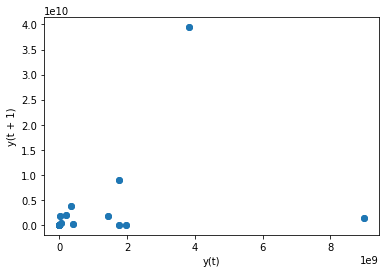

In [39]:
plt.figure()
spacing = np.linspace(-99 * np.pi, 99 * np.pi, num=1000)

data = summary_stats

lag_plot(data)


lag_plot(data) 
plt.show()

In [ ]:

# # Data to plot
# labels = '2017', '2018', '2019', '2020'
# sizes = [215, 130, 245, 210]
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
# explode = (0.1, 0, 0, 0) # explode 1st slice
 
# # Plot
# plt.pie(sizes, explode=explode, labels=labels, colors=colors,
#  autopct='%1.1f%%', shadow=True, startangle=140)
 
# plt.axis('equal')
# plt.show()
pie_plot = summary_stats.plot(kind="pie", y='mean', title=("Means"))
pie_plot.set_ylabel("Means")

plt.show()
plt.axis("equal")

In [ ]:
#When we use the gkey:
import gmaps
from config import gkey

gmaps.configure(api_key=gkey)

coordinates = int(input("What are the coordinates you would like to search for?"))




In [ ]:
figure_layout = {'width': '400px', 'height': '300px', 'border': '1px solid black' , 'padding': '1px', 'margin': '0 auto 0 auto'}
fig = gmaps.figure(layout=figure_layout)

markers = gmaps.marker_layer(coordinates)

fig.add_layer(markers)
fig

In [ ]:
pie_plot = summary_stats.plot(kind="pie", y='mean', title=("Means"))
pie_plot.set_ylabel("Means")

plt.show()
plt.axis("equal")